## Enunciado da Questão

Considere o problema de classificação de padrões bidimensionais constituído neste caso de 5 padrões. A distribuição dos padrões tem como base um quadrado centrado na origem interceptando os eixos nos pontos +1 e -1 de cada eixo. Os pontos +1 e -1 de cada eixo são centros de quatro semicírculos que se interceptam no interior do quadrado originando quatro classes e a quinta classe corresponde as regiões de não interseção. Após gerar aleatoriamente os dados que venham formar estas distribuições, selecione um conjunto de treinamento e um conjunto de teste. Defina a arquitetura da rede Deep MLP, treine a rede neural e apresente o desempenho da rede, no caso um classificador neural usando o conjunto de teste, calculando: a matriz de confusão, acurácia, recall, precisão e f1-score. 


### 1. Gerando os dados

 Classe 0: 655 pontos (43.67%)
 Classe 1: 208 pontos (13.87%)
 Classe 2: 213 pontos (14.20%)
 Classe 3: 207 pontos (13.80%)
 Classe 4: 217 pontos (14.47%)


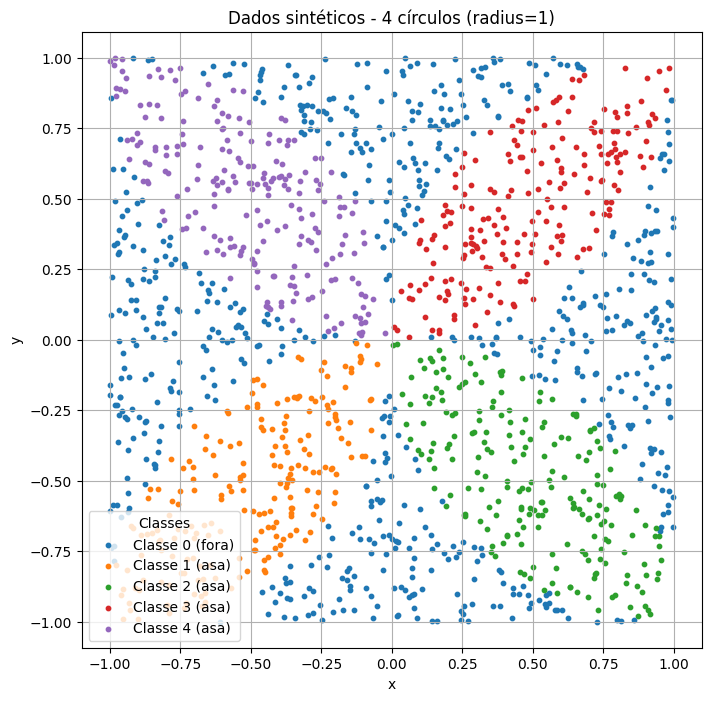

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N_POINTS = 1500
RADIUS = 1
TEST_SIZE = 0.2

# Gera pontos uniformes no quadro [-1, 1] x [-1, 1]
X = np.random.uniform(low=-1, high=1, size=(N_POINTS, 2))

# Centos dos 4 círculos
centers = np.array([[1, 0], [-1, 0], [0, -1], [0, 1]])

# Para cada ponto, calcula se está dentro de dois cículos círculo
squared_distances = np.sum((X[:, None, :] - centers[None, :, :]) ** 2, axis=2)
inside_each_circle = squared_distances <= RADIUS ** 2

# Verifica se está dentro de pelo menos dois circulos
inside_two_or_more = np.sum(inside_each_circle, axis=1) >= 2

# Criar array de classes vazio
y = np.zeros(len(X), dtype=int)

# Aplica classificação por quadrantes apenas para os que estão dentro de ≥ 2 círculos
mask = inside_two_or_more
x1, x2 = X[mask, 0], X[mask, 1]

y[mask & (X[:, 0] < 0) & (X[:, 1] < 0)] = 1
y[mask & (X[:, 0] > 0) & (X[:, 1] < 0)] = 2
y[mask & (X[:, 0] > 0) & (X[:, 1] > 0)] = 3
y[mask & (X[:, 0] < 0) & (X[:, 1] > 0)] = 4

# Verificar distribuição das classes
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f' Classe {u}: {c} pontos ({c / N_POINTS * 100:.2f}%)')

# Visualização inicial dos dados
plt.figure(figsize=(8,8))
#sc = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k', linewidth=0.5, s=20)
plt.scatter(X[y==0,0], X[y==0,1], s=10, alpha=1, label='Classe 0 (fora)')
plt.scatter(X[y==1,0], X[y==1,1], s=10, alpha=1, label='Classe 1 (asa)')
plt.scatter(X[y==2,0], X[y==2,1], s=10, alpha=1, label='Classe 2 (asa)')
plt.scatter(X[y==3,0], X[y==3,1], s=10, alpha=1, label='Classe 3 (asa)')
plt.scatter(X[y==4,0], X[y==4,1], s=10, alpha=1, label='Classe 4 (asa)')



plt.legend(loc='upper right')
plt.legend(title='Classes')
plt.title(f'Dados sintéticos - 4 círculos (radius={RADIUS})')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
plt.show()

In [2]:
from sklearn.model_selection import train_test_split

# Separando entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y
)

print(f'Shape do treinamento: {X_train.shape}')
print(f'Shape do teste: {X_test.shape}')

Shape do treinamento: (1200, 2)
Shape do teste: (300, 2)


### 2. Classificando usando PyTorch

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X_train, y_train):
        super().__init__()
        self.X = torch.from_numpy(X_train).type(torch.FloatTensor)
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len
    
data_train = CustomDataset(X_train, y_train)
data_test = CustomDataset(X_test, y_test)

train_loader = DataLoader(dataset=data_train, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=8, shuffle=True)

class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.layer3 = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [4]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [5]:
import torch
import torch.nn as nn

# Definição do modelo e hiperparâmetros
model = Classifier(input_size=2, hidden_size=10, output_size=5)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

NUM_EPOCHS = 100

# Função de acurácia melhorada
def acc_fn(y_true, y_pred):
    return (y_true == y_pred).float().mean().item()

# Loop de treinamento
for epoch in range(NUM_EPOCHS):
    # --- Treino ---
    model.train()
    train_loss, train_acc = 0.0, 0.0

    for x, y in train_loader:
        # Forward
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        
        # Acurácia
        acc = acc_fn(y, y_hat.argmax(dim=1))

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumula métricas
        train_loss += loss.item()
        train_acc += acc

    # Médias por época
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # --- Exibição de resultados ---
    if epoch % 10 == 0 or epoch == NUM_EPOCHS - 1:
        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
            f"| Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%"
        )


Epoch [1/100] | Train Loss: 0.9593 | Train Acc: 54.25%
Epoch [11/100] | Train Loss: 0.2312 | Train Acc: 90.42%
Epoch [21/100] | Train Loss: 0.1780 | Train Acc: 92.92%
Epoch [31/100] | Train Loss: 0.1645 | Train Acc: 94.00%
Epoch [41/100] | Train Loss: 0.1580 | Train Acc: 94.67%
Epoch [51/100] | Train Loss: 0.1351 | Train Acc: 94.67%
Epoch [61/100] | Train Loss: 0.1432 | Train Acc: 94.42%
Epoch [71/100] | Train Loss: 0.1649 | Train Acc: 93.92%
Epoch [81/100] | Train Loss: 0.1144 | Train Acc: 95.42%
Epoch [91/100] | Train Loss: 0.1333 | Train Acc: 95.00%
Epoch [100/100] | Train Loss: 0.1570 | Train Acc: 94.33%


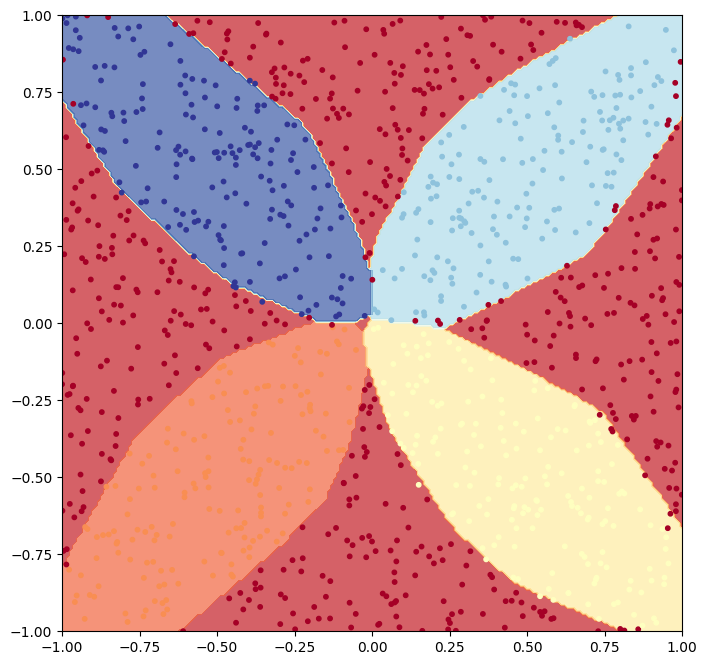

In [6]:
# Decision Boundaries
xx, yy = np.meshgrid(np.arange(-1,1.01,0.01), 
                     np.arange(-1,1.01,0.01))

X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).to(torch.float32)

# Fazendo as predições
model.eval()
with torch.inference_mode():
    y_proba = model(X_to_pred_on)
    y_pred = y_proba.argmax(dim=1)

# Reshape preds and plot
y_pred = y_pred.reshape(xx.shape).detach().numpy()
plt.figure(figsize=(8,8))
plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()


In [7]:
from sklearn.metrics import classification_report

model.eval()
with torch.inference_mode():
    y_proba = model(torch.from_numpy(X_test).to(torch.float32))
    y_pred = y_proba.argmax(dim=1)

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       131
           1       1.00      0.98      0.99        42
           2       0.95      0.93      0.94        43
           3       0.91      0.98      0.94        41
           4       0.95      0.95      0.95        43

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300

